In [43]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

import kex_data
import kex_headers
import petlink
import representation
import position
import listmode
import visual
import time
import importlib

In [23]:
listmode_dataset, listmode_paths = kex_data.listmode()

phantoms = ["cylinder", "cannula"]
gates = ["0", "1"]
keys = []
for p in phantoms:
    for g in gates:
        keys.append(p + " " + g)
print("paths\n", listmode_paths)
print("keys\n", keys)
limo_dict = dict(zip(keys, listmode_dataset))

paths
 ['C:/Users/petct/Desktop/CylinderPET-Converted/CylinderPET-LM-00/CylinderPET-LM-00.l', 'C:/Users/petct/Desktop/CylinderPET-Converted/CylinderPET-LM-01/CylinderPET-LM-01.l', 'C:/Users/petct/Desktop/KanylPET-Converted/KanylPET-LM-00/KanylPET-LM-00.l', 'C:/Users/petct/Desktop/KanylPET-Converted/KanylPET-LM-01/KanylPET-LM-01.l']
keys
 ['cylinder 0', 'cylinder 1', 'cannula 0', 'cannula 1']


In [88]:
#take the mean normalization of the gates, for the whole list
normfactors, _ = kex_data.get_norm_factors()
normfactors = dict(zip(keys, normfactors))

In [136]:
importlib.reload(listmode)
limo_recon = {}
toflor = {}
norms = {}
for key in keys:
    time_a = time.time()
    limo_recon[key] = listmode.get_fov_image_bins(limo_dict[key])
    argu = {'tof_lor_bins':limo_recon[key]['tof_lor'],
           'is_prompt':limo_recon[key]['is_prompt'],
           'normfactors':normfactors[key]}
    norms[key] = listmode.get_norms(**argu)
    time_b = time.time()
    print("elapsed time", time_b-time_a)

elapsed time 13.408144474029541
elapsed time 13.722818851470947
elapsed time 26.09529709815979
elapsed time 26.79235291481018


In [229]:
#get com traces for different time steps
timesteps = np.logspace(0,4,30,dtype=int)
timesteps = np.unique(timesteps) #remove redundant 1s at start

time_a = time.time()
timetags = {}
for key,value in limo_dict.items(): 
    timetag_indices = petlink.get_timetag_indices(value)
    d = limo_recon[key]
    conditions = [d['is_event'], d['is_prompt'], d['is_image_fov']]
    for c in conditions:
        timetag_indices = listmode.transmit_indices(timetag_indices, c)
    timetags[key] = timetag_indices #constant w.r.t. timesteps
print("timetags processing time", time.time()-time_a)


timestep_com = {}
for step in timesteps:
    time_a = time.time()
    trace = {}
    for key, value in limo_recon.items():
        split_indices = petlink.get_timeslice_indices(timetags[key], step)
        argu = {'listmode_data':limo_recon[key]['fov_image_bins'],
               'split_indices':split_indices,
               'masses':norms[key][value['is_image_fov']]}
        trace[key] = position.get_center_trace(**argu)
    timestep_com[step] = trace
    print("timestep " + str(step) +" runtime", time.time()-time_a)

timetags processing time 4.166892051696777
timestep 1 runtime 8.574069738388062
timestep 2 runtime 6.127612590789795
timestep 3 runtime 5.335700035095215
timestep 4 runtime 5.110368013381958
timestep 6 runtime 4.6575117111206055
timestep 9 runtime 4.522905111312866
timestep 12 runtime 4.2935497760772705
timestep 17 runtime 3.9673943519592285
timestep 23 runtime 3.826756238937378
timestep 32 runtime 3.7460033893585205
timestep 45 runtime 4.022273063659668
timestep 62 runtime 3.8846092224121094
timestep 85 runtime 4.636634111404419
timestep 117 runtime 4.728322267532349
timestep 161 runtime 4.690456867218018
timestep 221 runtime 4.887928485870361
timestep 303 runtime 5.080415964126587
timestep 417 runtime 5.235996246337891
timestep 573 runtime 4.799166202545166
timestep 788 runtime 5.179149866104126
timestep 1082 runtime 4.92283296585083
timestep 1487 runtime 4.718381404876709
timestep 2043 runtime 4.721373081207275
timestep 2807 runtime 4.608675479888916
timestep 3856 runtime 4.80914020

In [230]:
timestep_std = {}
for step,t_com in timestep_com.items():
    timestep_std[step]={key: np.std(com, axis=1) for key,com in t_com.items()}

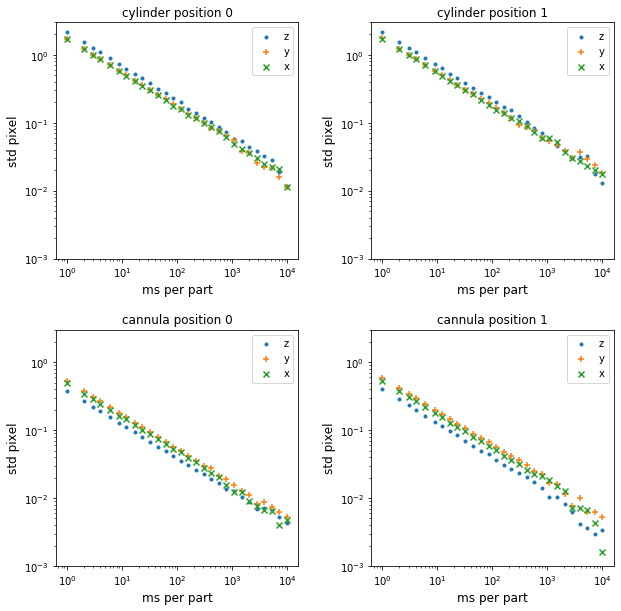

In [305]:
fig, axes = plt.subplots(nrows=len(phantoms), ncols=len(gates), figsize=(10,10))
fontsize='large'
markers=['.','+','x']
for pha,row in enumerate(axes):
    for gat,ax in enumerate(row):
        key = phantoms[pha]+" "+gates[gat]
        for dim, dim_name in enumerate(kex_headers.IMAGE_DIMENSION_TITLES):
            dim_std=[std[key][dim] for t,std in timestep_std.items()]
            x=[t for t in timestep_std]
            ax.scatter(x, dim_std, label=dim_name,marker=markers[dim])
        ax.legend()
        ax.set_xlabel('ms per part', fontsize=fontsize)
        ax.set_ylabel('std pixel', fontsize=fontsize)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim(0.001,3)
        ax.set_title(" position ".join(key.split(" ")), fontsize=fontsize)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('image_results/precision/time_std')

In [241]:
#what happends if we compensate for the different activity rates?
event_steps= np.unique(np.logspace(3,6,30,dtype=int))
event_step_com = {}
for step in event_steps:
    time_a = time.time()
    trace = {}
    for key, value in limo_recon.items():
        N = len(value['fov_image_bins'][0])
        split_indices = np.arange(step,N,step)
        argu = {'listmode_data':value['fov_image_bins'],
               'split_indices':split_indices,
               'masses':norms[key][value['is_image_fov']]}
        trace[key] = position.get_center_trace(**argu)
    event_step_com[step] = trace
    print("event step " + str(step) +" runtime", time.time()-time_a)

event step 1000 runtime 5.753612995147705
event step 1268 runtime 5.162230014801025
event step 1610 runtime 5.112325191497803
event step 2043 runtime 4.542852878570557
event step 2592 runtime 4.264594078063965
event step 3290 runtime 4.3842432498931885
event step 4175 runtime 4.154891490936279
event step 5298 runtime 3.9993364810943604
event step 6723 runtime 3.8656649589538574
event step 8531 runtime 3.850701332092285
event step 10826 runtime 3.6861414909362793
event step 13738 runtime 3.968388795852661
event step 17433 runtime 4.183590412139893
event step 22122 runtime 4.025651693344116
event step 28072 runtime 3.87892484664917
event step 35622 runtime 3.83489727973938
event step 45203 runtime 4.888930797576904
event step 57361 runtime 4.859039783477783
event step 72789 runtime 4.93679404258728
event step 92367 runtime 4.633582592010498
event step 117210 runtime 4.937786102294922
event step 148735 runtime 4.838062763214111
event step 188739 runtime 4.561831951141357
event step 239502

In [242]:
event_step_std = {}
for step,t_com in event_step_com.items():
    event_step_std[step]={key: np.std(com, axis=1) for key,com in t_com.items()}

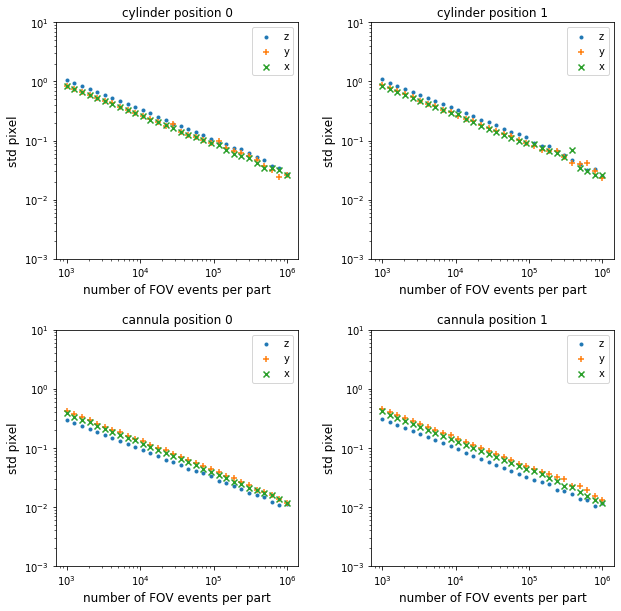

In [304]:
fig, axes = plt.subplots(nrows=len(phantoms), ncols=len(gates), figsize=(10,10))
fontsize='large'
markers=['.','+','x']
for pha,row in enumerate(axes):
    for gat,ax in enumerate(row):
        key = phantoms[pha]+" "+gates[gat]
        for dim, dim_name in enumerate(kex_headers.IMAGE_DIMENSION_TITLES):
            dim_std=[std[key][dim] for t,std in event_step_std.items()]
            x=[t for t in event_step_std]
            ax.scatter(x, dim_std, label=dim_name,marker=markers[dim])
        ax.legend()
        ax.set_xlabel('number of FOV events per part', fontsize=fontsize)
        ax.set_ylabel('std pixel', fontsize=fontsize)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim(0.001,10)
        ax.set_title(" position ".join(key.split(" ")), fontsize=fontsize)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('image_results/precision/event_std')

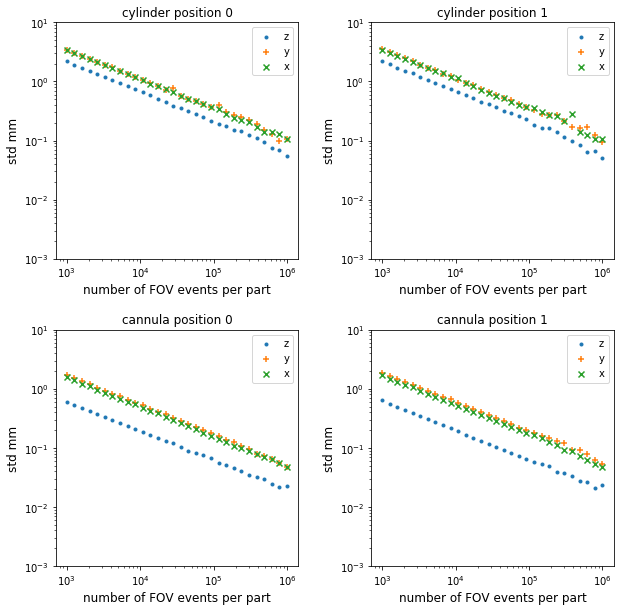

In [303]:
#what happends when accounting for pixel mm?
fig, axes = plt.subplots(nrows=len(phantoms), ncols=len(gates), figsize=(10,10))
fontsize='large'
markers=['.','+','x']
for pha,row in enumerate(axes):
    for gat,ax in enumerate(row):
        key = phantoms[pha]+" "+gates[gat]
        for dim, dim_name in enumerate(kex_headers.IMAGE_DIMENSION_TITLES):
            dim_std=[std[key][dim] for t,std in event_step_std.items()]
            dim_std = np.array(dim_std)*kex_headers.MM_PER_PIXEL[dim]
            x=[t for t in event_step_std]
            ax.scatter(x, dim_std, label=dim_name,marker=markers[dim])
        ax.legend()
        ax.set_xlabel('number of FOV events per part', fontsize=fontsize)
        ax.set_ylabel('std mm', fontsize=fontsize)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim(0.001,10)
        ax.set_title(" position ".join(key.split(" ")), fontsize=fontsize)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('image_results/precision/event_std_mm')

In [274]:
#what happends with std if we have movement?
phantom_com = {step: 
               {pha: listmode.join_gates([event_step_com[step][pha+" "+gat] for gat in gates])
                for pha in phantoms} for step in event_steps}
phantom_std = {}
for step,t_com in phantom_com.items():
    phantom_std[step]={key: np.std(com, axis=1) for key,com in t_com.items()}

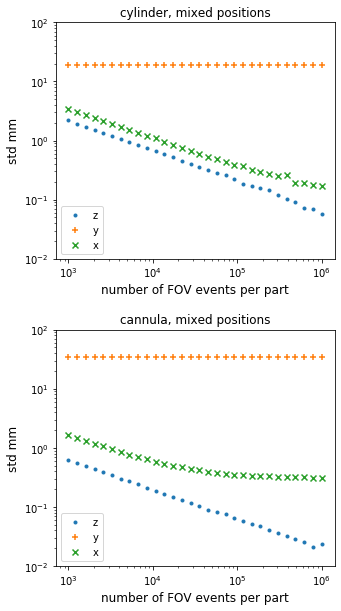

In [306]:
fig, axes = plt.subplots(nrows=len(phantoms), ncols=1, figsize=(5,10))
fontsize='large'
markers=['.','+','x']
for rownum,ax in enumerate(axes):
        key = phantoms[rownum]
        for dim, dim_name in enumerate(kex_headers.IMAGE_DIMENSION_TITLES):
            dim_std=[std[key][dim] for t,std in phantom_std.items()]
            dim_std = np.array(dim_std)*kex_headers.MM_PER_PIXEL[dim]
            x=[t for t in phantom_std]
            ax.scatter(x, dim_std, label=dim_name,marker=markers[dim])
        ax.legend()
        ax.set_xlabel('number of FOV events per part', fontsize=fontsize)
        ax.set_ylabel('std mm', fontsize=fontsize)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim(0.01,100)
        ax.set_title(key + ", mixed positions", fontsize=fontsize)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('image_results/precision/mixed_std')

In [90]:
recons, recon_paths = kex_data.reconstructions()
recon_dict = dict(zip(keys, recons))
recon_com = {key: np.array(position.center_of_mass(recon_dict[key])) for key in keys}

In [91]:
# join gates
phantom_traces = {pha: listmode.join_gates([com_traces[pha+" "+gat] for gat in gates]) for pha in phantoms}

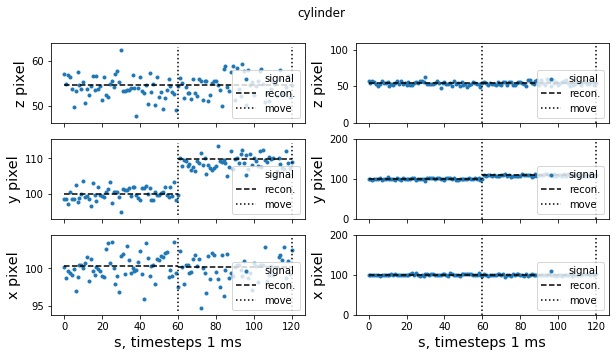

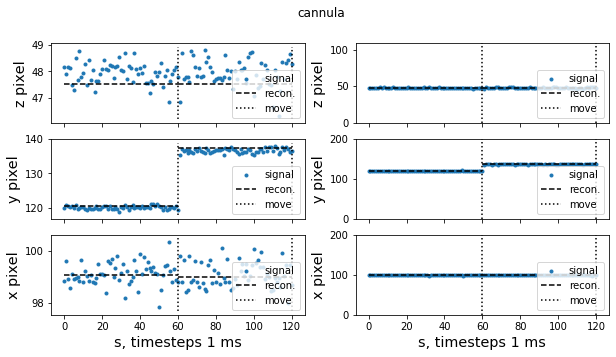

In [307]:
importlib.reload(visual)
legends = ["signal", "recon.", "move"]
hlabel = "s, timesteps {} ms".format(timestep)
for pha in phantoms:
    N = phantom_traces[pha].shape[-1]
    sample=1000
    hvalues = np.arange(N/sample)*timestep 
    gate_timecounts = [com_traces[pha+" "+gat].shape[-1] for gat in gates]
    vlines = np.array(np.cumsum(gate_timecounts))*timestep/1000 #convert from ms to seconds
    hlines_fromto = [[0] + list(vlines[:-1]), vlines]
    trace = phantom_traces[pha][:, ::sample]
    hlines = np.array([recon_com[pha+" "+gat] for gat in gates])
    hlines = np.swapaxes(hlines, 0,1)
    visual.plot_com_trace(trace, 
                          title=pha, 
                          legends=legends, 
                          hvalues=hvalues, 
                          hlabel=hlabel, 
                          vlines=vlines,
                          space_shape=kex_headers.IMAGE_SHAPE,
                          dim_str=[dim+" pixel" for dim in kex_headers.IMAGE_DIMENSION_TITLES],
                          hlines=hlines,
                          hlines_fromto=hlines_fromto,
                          marker='.',
                          sharex='col', 
                          sharey=False,
                          figsize=(10,5))
    
    plt.savefig("image_results/precision/"+pha + str(timestep) + "ms")
    plt.show()

In [ ]:
def amp_gate_data(signal, amp_steps):
    amp_signal = (np.round(signal.T/amp_steps)*amp_steps).T
    return amp_signal

In [ ]:
amp_steps = np.array(kex_headers.MM_PER_PIXEL)
test_sig = com_traces_mm[1]
sig = amp_gate_data(test_sig, amp_steps)

In [ ]:
plt.plot(test_sig[1], 'b')
plt.plot(sig[1], 'r')


In [ ]:
plt.plot(np.sum(np.diff(sig, axis=1),axis=0) != 0);

In [ ]:
from scipy import stsci

In [ ]:
def boxcar(sig, width, **kwargs):
    boxshape = (sig.shape[0], width) if sig.ndim > 0 else (width,)
    return scipy.statsci.convolve.boxcar(sig, boxshape, **kwargs)

In [ ]:
box_sig = boxcar(test_sig, 3)